🚀 启动 [指挥官模式] 稳定性测试 | 目标模型: SVM
   📂 路径前缀: 'notebooks/'
   - 数据引擎: notebooks/01_feature_engineering.ipynb
   - 模型引擎: notebooks/03_final_training_svm.ipynb

>>> 开始 10 轮压力测试...

🔄 [Round 1/10] Injecting Seed 42 ...
   ✅ 完成! Test R2 = 0.5600

🔄 [Round 2/10] Injecting Seed 123 ...
   ✅ 完成! Test R2 = 0.6678

🔄 [Round 3/10] Injecting Seed 2024 ...
   ✅ 完成! Test R2 = -0.3947

🔄 [Round 4/10] Injecting Seed 888 ...
   ✅ 完成! Test R2 = 0.8164

🔄 [Round 5/10] Injecting Seed 666 ...
   ✅ 完成! Test R2 = 0.5216

🔄 [Round 6/10] Injecting Seed 1 ...
   ✅ 完成! Test R2 = 0.6299

🔄 [Round 7/10] Injecting Seed 7 ...
   ✅ 完成! Test R2 = 0.2431

🔄 [Round 8/10] Injecting Seed 99 ...
   ✅ 完成! Test R2 = 0.3222

🔄 [Round 9/10] Injecting Seed 100 ...
   ✅ 完成! Test R2 = 0.6112

🔄 [Round 10/10] Injecting Seed 288 ...
   ✅ 完成! Test R2 = 0.6600

📊 SVM 稳定性测试报告
   Mean R2 : 0.4637 (中心趋势)
   Std Dev : 0.3274 (波动幅度)
🖼️  美图已保存: figures\Stability_Runner_SVM_EST.png


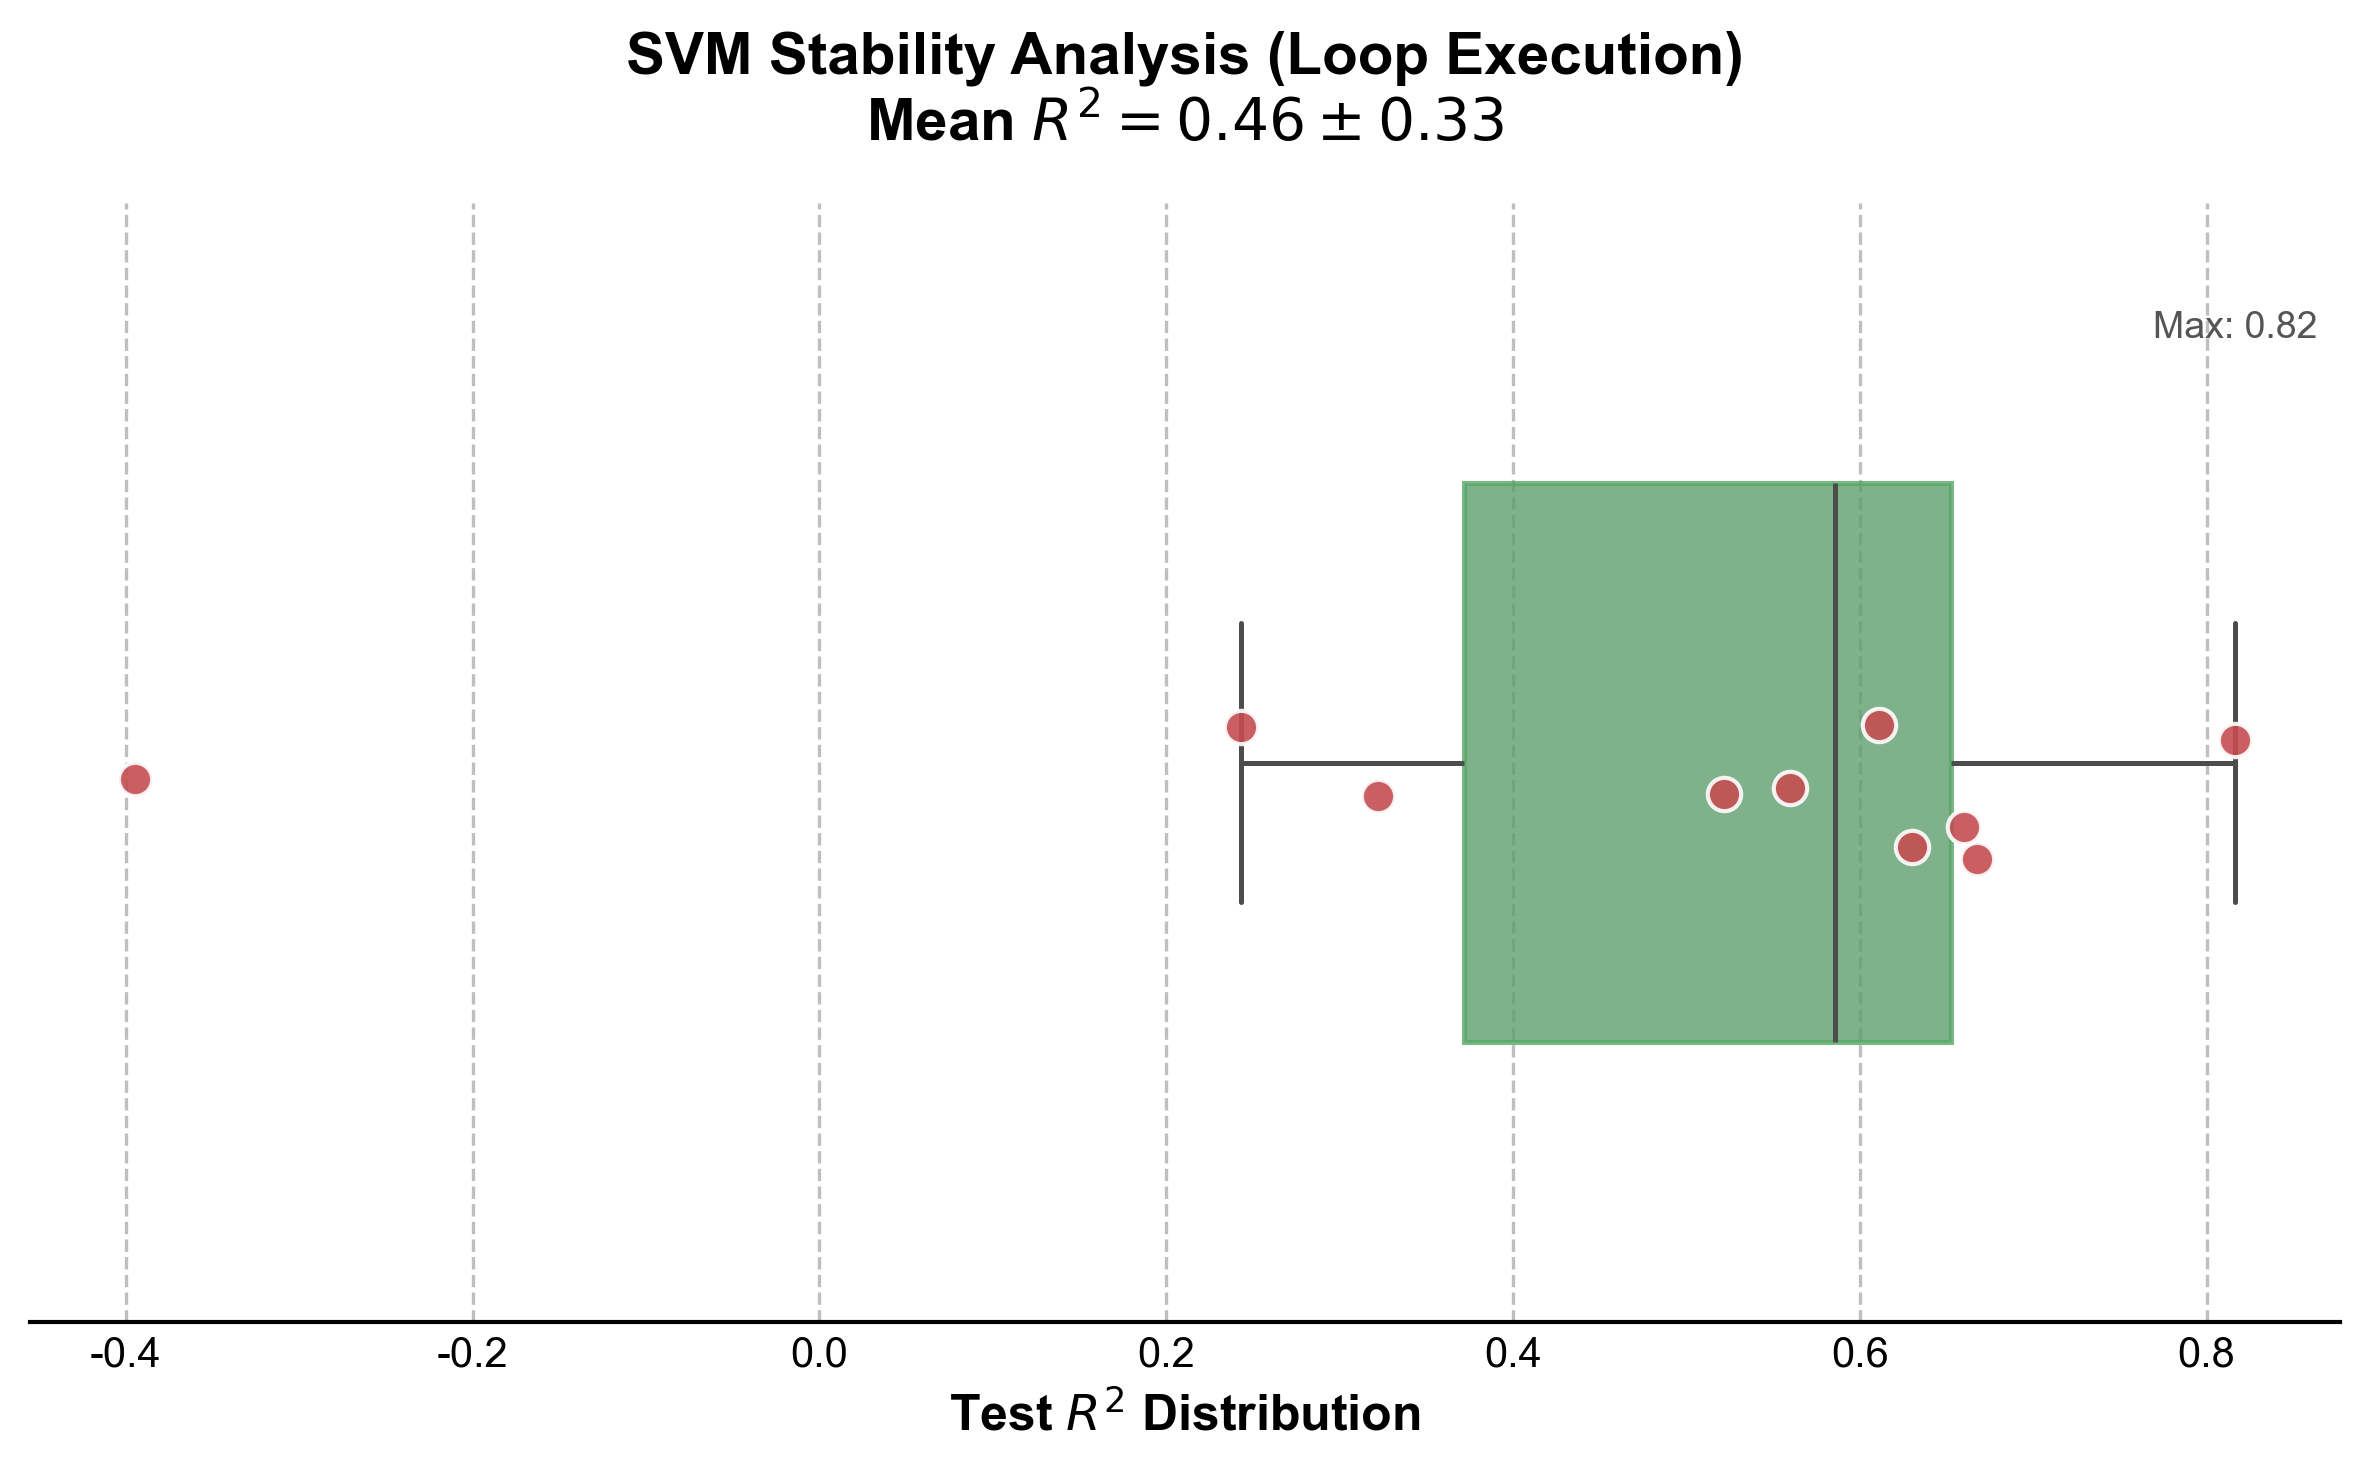

In [10]:
# ==========================================
# File: project_cdft/notebooks/05_stability_test.ipynb
# ==========================================
# 核心功能:
# 1. [指挥官模式] 不定义模型，直接调用 01 和 03 号文件 (Meta-Programming)
# 2. [控制变量] 循环修改 Random Seed，测试模型在不同数据划分下的表现
# 3. [视觉风格] ES&T 期刊标准: 白底 + 鼠尾草绿箱体 + 砖红散点
# 4. [智能路径] 自动识别 notebooks 路径，防止"找不到文件"错误

import os
import time
import subprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score

# ========================================================
# 🎛️ 总控台：在这里修改你要测试的模型
# ========================================================
TARGET_MODEL = "svm"   # 选项: "xgb", "svm", "rf" ...
# ========================================================

# 1. 环境准备 & 智能路径导航
# --------------------------------------------------------
# 先尝试退回到项目根目录，以便统一路径视角
if 'notebooks' in os.getcwd(): os.chdir('..')
model_tag = TARGET_MODEL.lower()

# 🔍 自动侦测兵营位置 (notebooks 文件夹)
# 无论是在根目录运行，还是在 notebooks 里运行，都能找到正确路径
if os.path.exists("notebooks/01_feature_engineering.ipynb"):
    nb_prefix = "notebooks/"
elif os.path.exists("01_feature_engineering.ipynb"):
    nb_prefix = ""
else:
    # 严重错误：连 01 号文件都找不到
    print("❌ 严重错误: 找不到 01_feature_engineering.ipynb")
    print("   请确认你是在项目根目录下，或者 notebooks 文件夹结构正确。")
    # 这里设置一个默认值防止代码直接崩溃，但后续肯定会报错
    nb_prefix = ""

# 定义带路径的任务文件名
task_feature = f"{nb_prefix}01_feature_engineering.ipynb"
task_model   = f"{nb_prefix}03_final_training_{model_tag}.ipynb"

# 定义配置文件和结果文件的路径 (相对根目录)
seed_config_file = "current_seed_config.txt"
pred_file = "results/predictions/final_predictions.csv"

print(f"🚀 启动 [指挥官模式] 稳定性测试 | 目标模型: {model_tag.upper()}")
print(f"   📂 路径前缀: '{nb_prefix}'")
print(f"   - 数据引擎: {task_feature}")
print(f"   - 模型引擎: {task_model}")

# Double Check: 确保 03 号文件也存在，不然别跑了
if not os.path.exists(task_model):
    raise FileNotFoundError(f"❌ 找不到模型文件: {task_model}。请检查是否已创建该模型的 03 号文件。")

# ========================================================
# [Step 1] 循环调度 (The Loop)
# ========================================================
# 选取10个具有代表性的随机种子
SEEDS = [42, 123, 2024, 888, 666, 1, 7, 99, 100, 288]
results = []
best_score = -999; best_seed = None

print(f"\n>>> 开始 10 轮压力测试...")
start_total = time.time()

for i, seed in enumerate(SEEDS):
    print(f"\n🔄 [Round {i+1}/10] Injecting Seed {seed} ...")

    # 1. 写纸条 (下达种子指令给 01 号文件)
    with open(seed_config_file, "w") as f:
        f.write(str(seed))

    # 2. 调用 01 号文件 (重组数据)
    # --execute: 运行
    # --inplace: 不仅运行，还将运行结果写回原文件
    cmd_feat = f"jupyter nbconvert --to notebook --execute --inplace {task_feature}"

    # 使用 subprocess 调用系统命令
    proc_feat = subprocess.run(cmd_feat, shell=True, capture_output=True)

    if proc_feat.returncode != 0:
        print(f"❌ 01 数据工程执行失败! Seed={seed}")
        # 打印错误日志的最后500个字符，方便调试
        print(proc_feat.stderr.decode('utf-8', errors='ignore')[-500:])
        break

    # 3. 调用 03 号文件 (训练模型并预测)
    cmd_model = f"jupyter nbconvert --to notebook --execute --inplace {task_model}"
    proc_model = subprocess.run(cmd_model, shell=True, capture_output=True)

    if proc_model.returncode != 0:
        print(f"❌ 03 模型训练执行失败! Model={model_tag}")
        print(proc_model.stderr.decode('utf-8', errors='ignore')[-500:])
        break

    # 4. 收作业 (读取预测结果计算 R2)
    if os.path.exists(pred_file):
        try:
            df_res = pd.read_csv(pred_file)
            # 自动兼容列名: 'Target' 或 'Target_Log1o2'
            y_true_col = 'Target' if 'Target' in df_res.columns else 'Target_Log1o2'

            score = r2_score(df_res[y_true_col], df_res['Predicted'])
            results.append(score)

            if score > best_score: best_score = score; best_seed = seed
            print(f"   ✅ 完成! Test R2 = {score:.4f}")

        except Exception as e:
            print(f"⚠️ 读取结果出错: {e}")
            break
    else:
        print(f"❌ 致命错误：未找到预测结果文件 {pred_file}")
        break

# 打扫战场：删除种子配置文件，以免影响后续手动运行
if os.path.exists(seed_config_file): os.remove(seed_config_file)

# ========================================================
# [Step 2] 绘图 (ES&T 风格: 白底/绿箱/红点)
# ========================================================
# 只有当所有轮次都跑完才画图
if len(results) == len(SEEDS):
    results_arr = np.array(results)
    mean_r2 = np.mean(results_arr)
    std_r2 = np.std(results_arr)

    print("\n" + "="*45)
    print(f"📊 {model_tag.upper()} 稳定性测试报告")
    print(f"   Mean R2 : {mean_r2:.4f} (中心趋势)")
    print(f"   Std Dev : {std_r2:.4f} (波动幅度)")
    print("="*45)

    # --- 字体与背景设置 ---
    plt.rcParams['font.family'] = 'sans-serif'
    # 优先使用 Arial, Helvetica，如果没有则回退到 DejaVu Sans
    plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']

    fig, ax = plt.subplots(figsize=(8, 5), dpi=300)
    # 纯白背景 (符合出版要求)
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')

    # --- 核心配色 (ES&T Style) ---
    # 鼠尾草绿 (#55A868): 箱体 - 代表模型整体分布
    # 砖红 (#C44E52): 散点 - 代表具体的测试集分数
    BOX_COLOR = '#55A868'
    POINT_COLOR = '#C44E52'

    # 1. 绘制箱线图
    sns.boxplot(x=results, color=BOX_COLOR, width=0.5, ax=ax,
                fliersize=0, linewidth=1.2,
                boxprops=dict(alpha=0.8, edgecolor=BOX_COLOR))

    # 2. 绘制散点图 (带白色描边)
    sns.stripplot(x=results, color=POINT_COLOR, size=8, jitter=True, ax=ax,
                  edgecolor='white', linewidth=1.0, alpha=0.9)

    # 3. 装饰
    # 标题不包含 "Best Seed"，重点在 Mean +/- Std
    title_str = f'{model_tag.upper()} Stability Analysis (Loop Execution)\nMean $R^2={mean_r2:.2f} \pm {std_r2:.2f}$'
    ax.set_title(title_str, fontsize=14, fontweight='bold', pad=15, color='black')
    ax.set_xlabel('Test $R^2$ Distribution', fontsize=12, fontweight='bold', color='black')

    # 坐标轴与网格 (Inward ticks)
    ax.tick_params(axis='x', colors='black', labelsize=10, direction='in')
    ax.grid(True, linestyle='--', alpha=0.5, color='gray') # 淡灰色虚线网格

    # 边框设置
    for spine in ax.spines.values():
        spine.set_linewidth(1.0)
        spine.set_color('black')
    # 隐藏多余边框
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_yticks([]) # 不需要Y轴刻度

    # 弱化"最优值"标注 (Focus on Distribution)
    # 放在下方，字体较小，作为参考信息
    ax.text(best_score, -0.38, f'Max: {best_score:.2f}',
            color='#555555', ha='center', fontsize=9, fontweight='normal')

    # 保存
    os.makedirs('figures', exist_ok=True)
    # 文件名加上 EST 后缀以示区分
    save_name = f"Stability_Runner_{model_tag.upper()}_EST.png"
    save_path = os.path.join('figures', save_name)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"🖼️  美图已保存: {save_path}")
    plt.show()

else:
    print(f"\n⚠️ 测试未全部完成 (成功 {len(results)}/{len(SEEDS)})，跳过绘图。")
    print("   请检查上方报错信息，确保 01 和 03 号文件可以正常运行。")